## Решение задачи Регрессии

### Предсказывание цены дома при помощи линейной регресси, Lasso и Ridge

Датасет был взят с https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Задача Регрессии - один из типов задачи машинного обучения, целевой переменной (ответом, предсказанием) которой должно стать число. В данном случае - цена квартиры.

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import warnings

warnings.filterwarnings('ignore')
# some lib

In [103]:
data = pd.read_csv('train.csv', header=0)

In [104]:
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [105]:
data.shape

(1460, 81)

Проверим пропуски в признаках и выясним какие из признаков можно удалить.

In [106]:
nuns = data.isnull().sum()
nuns = nuns[nuns>0]
nuns

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


1. Можно удалить MiscFeature, PoolQC, Alley из-за большого количества пропусков/нулей вместо данных.
2. Большинство признаков, связанные с подвалом (basement) не несут никакой полезной информации. Можно оставить только BsmtCond & BsmtQual.
3. Удаляется столбец Id.

In [107]:
data = data.drop(['MiscFeature', 'PoolQC', 'Alley',
           'BsmtFinType1', 'BsmtFinSF1',
           'BsmtFinType2', 'BsmtFinSF2',
           'BsmtUnfSF', 'BsmtExposure', 'Id'], axis=1)

In [108]:
nuns = data.isnull().sum()
nuns = nuns[nuns>0]
nuns_percent = nuns/len(data)
print("Доля пропусков от общего числа значений: ")
print(nuns_percent)

Доля пропусков от общего числа значений: 
LotFrontage     0.177397
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
Fence           0.807534
dtype: float64


Пропущенные категориальные признаки объектов будут заполняться самым часто встречаемым значением данного признака.

In [109]:
category = data.select_dtypes('object').columns
for column in category:
  top_of_column = data[column].describe()["top"]
  data[column] = data[column].fillna(top_of_column)

Пропущенные числовые значения будут заполнены средним значением по признаку.

In [110]:
numeric = data.select_dtypes('float64').columns
for column in numeric:
  top_of_column = data[column].mean()
  data[column] = data[column].fillna(top_of_column)

In [111]:
nuns = data.isnull().sum()
nuns = nuns[nuns>0]
nuns

,0


Пропуски после заполнения отсутствуют.

In [112]:
data_copy = data.copy()

label_encoding = []
one_hot_encoding = []

In [113]:
for column in category:
  if(data_copy[column].nunique()==2):
    label_encoding.append(column)
  else:
    one_hot_encoding.append(column)

In [114]:
for column in label_encoding:
  data_copy[column] = LabelEncoder().fit_transform(data_copy[column])

In [115]:
data_copy = pd.get_dummies(data_copy, columns=one_hot_encoding, drop_first=True, dtype = int)

In [116]:
data_copy.head()

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,1,0,7,5,2003,2003,196.0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,1,0,6,8,1976,1976,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,1,0,7,5,2001,2002,162.0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,1,0,7,5,1915,1970,0.0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,1,0,8,5,2000,2000,350.0,...,0,0,0,0,1,0,0,0,1,0


In [117]:
data_corr = data.drop(labels=category, axis=1)

Таблица попарных коэффициентов корреляции Пирсона выглядит следующим образом:

<Axes: >

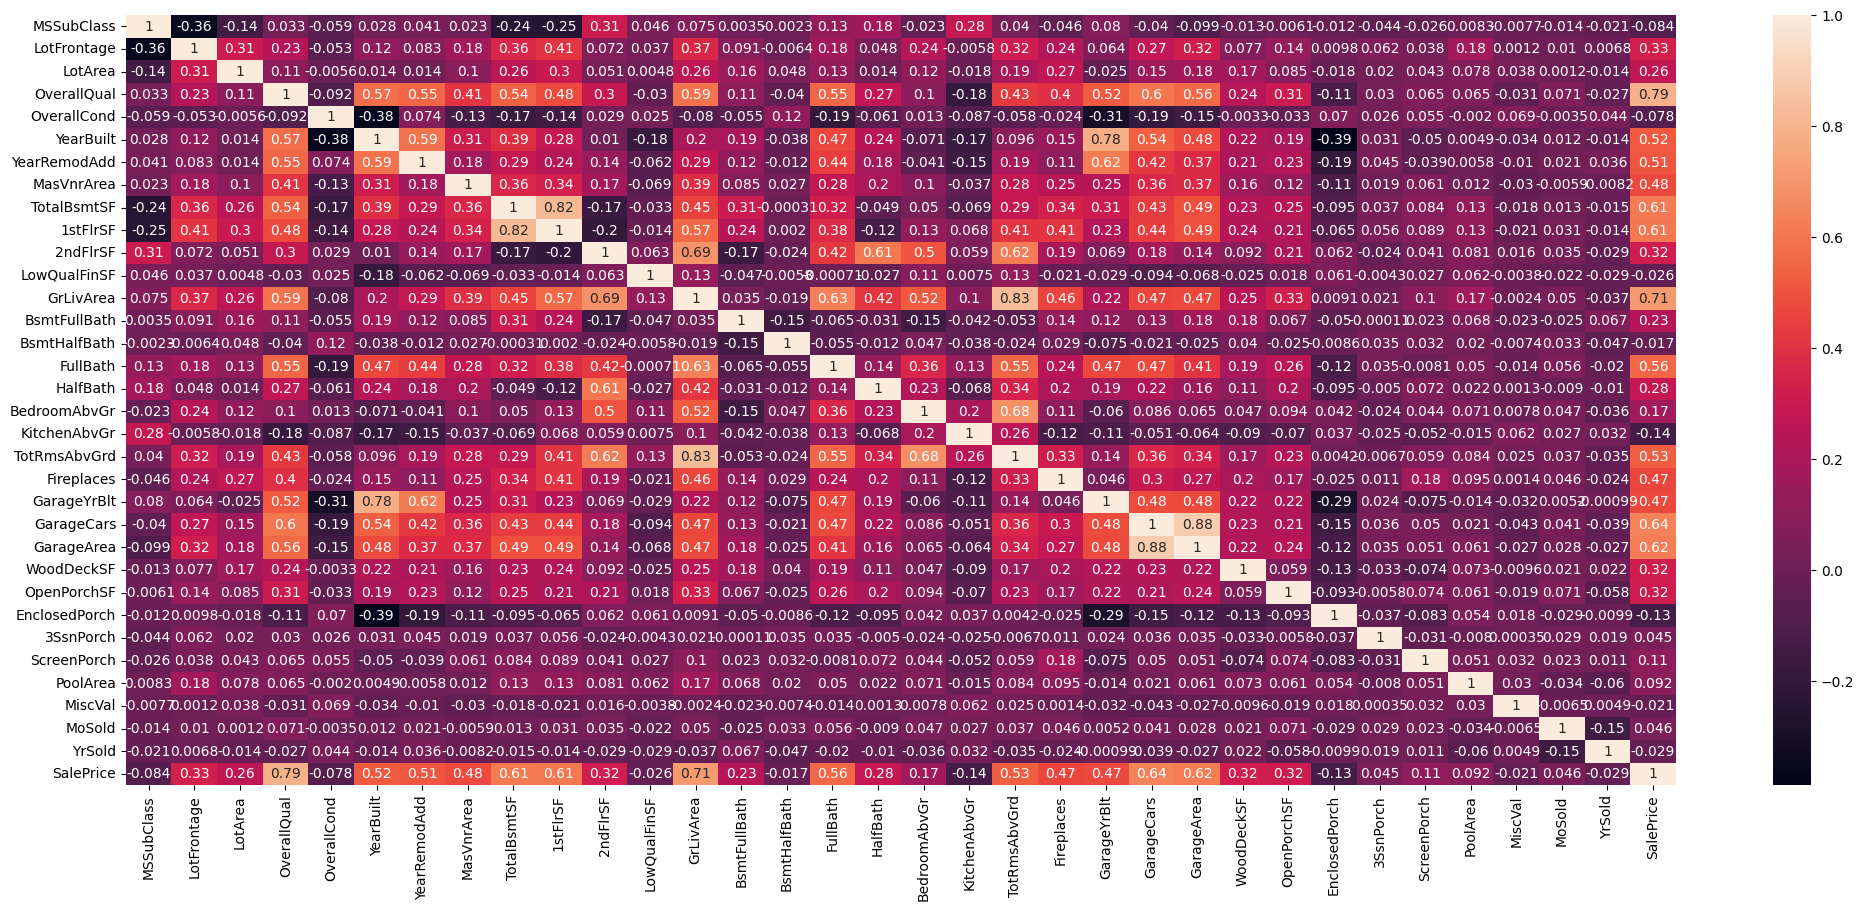

In [118]:
fig, ax = plt.subplots(figsize=(25,10))
data_corr = data_corr.corr()
sns.heatmap(data_corr, linewidths=0.001, annot=True)

Найдем абсолютные значения коэффициентов корреляции Пирсона с целевой переменнной SalePrice (или насколько сильно тот или иной признак коррелирует с итоговой ценой дома)

In [119]:
data_corr = data_corr.abs()

sol = (data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

features = []
corr = []

for index, value in sol.items():
  if(index[1] == 'SalePrice'):
    features.append(index[0])
    corr.append(value)

data_coef_corr = pd.DataFrame(corr, index = features, columns = ['SalePrice'])
data_coef_corr

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


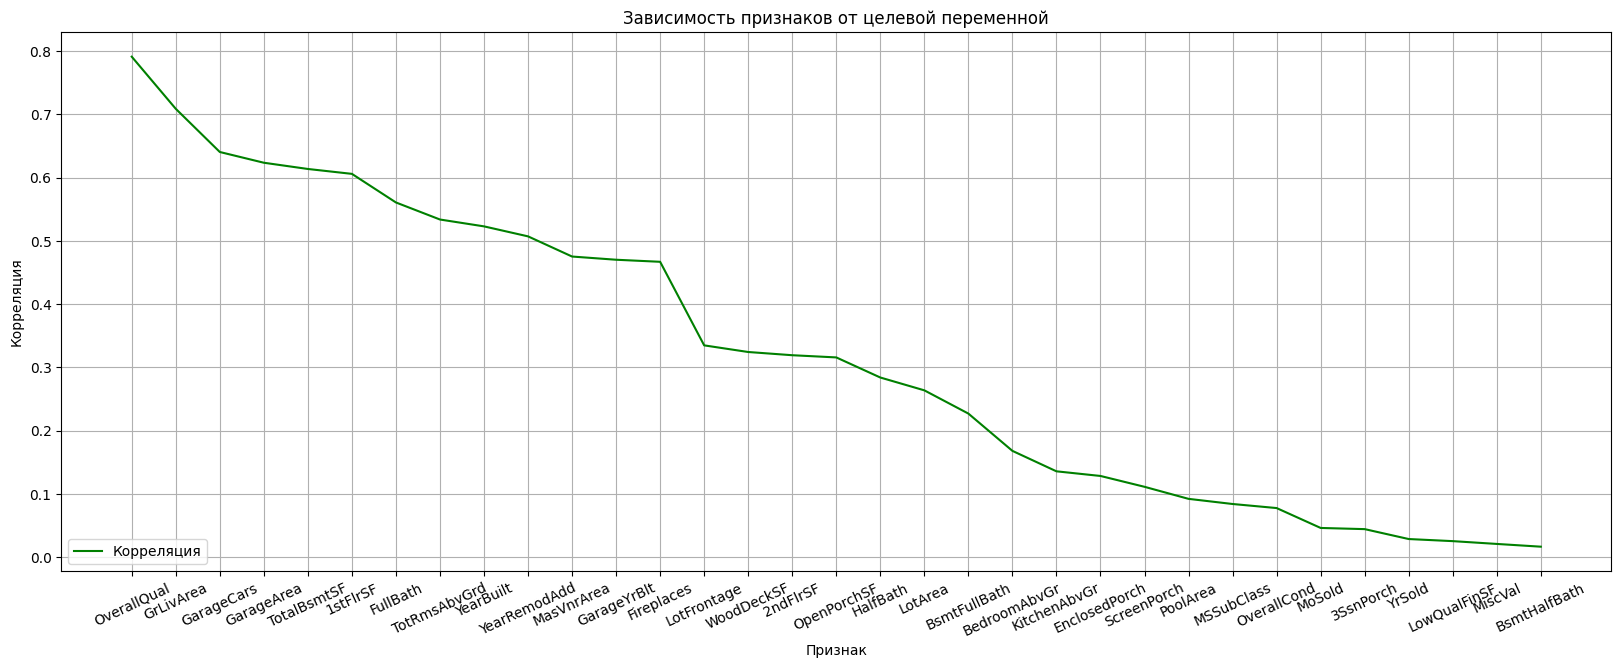

In [120]:
fig, ax = plt.subplots(figsize=(20,7))

x = features
y1 = corr

ax.plot(x, y1, color='green', label='Корреляция')
plt.xticks(rotation=25)

ax.grid(True)
plt.xlabel('Признак')
plt.ylabel('Корреляция')
plt.title('Зависимость признаков от целевой переменной')

leg = ax.legend(loc='lower left', frameon=True)

Больше всего с итоговым ответом коррелирует признак OverallQual - Общее качество ремонта дома.

Меньше всего коррелирует BsmtHalfBath - Наличие туалетов в подвале.

In [121]:
X = data_copy.drop('SalePrice', axis=1)
y = data['SalePrice']

Приведем цены квартир к виду x -> log(1+x) для избавления от разницы в масштабах, а так же избавления от смещения распределения в сторону нормального

В датасете содержится небольшое количество дорогих квартир, из-за чего происходит сильное смещение вправо. Логирование позволяет привести данные к более "нормальному" виду, сделать их более симметричными

Text(0, 0.5, 'Количество квартир')

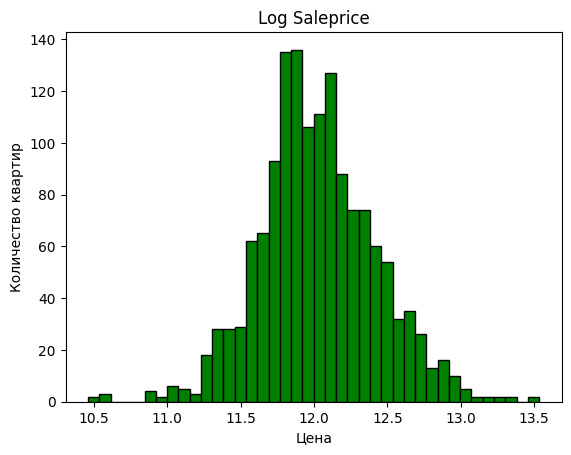

In [122]:
plt.hist(np.log1p(data['SalePrice']), color='green', edgecolor='black', bins=int(200/5))

plt.title('Log Saleprice')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')

In [123]:
np.random.seed(13)

Разобьем данные в отношении 75:25 на обучающие и тестовые. Также нужно прологарифмировать целевую переменную y.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y), test_size = 0.25)

##Линейная регрессия

In [ ]:
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)

In [126]:
print("lin_reg MSE train: ", mean_squared_error(math.e**(y_train)-1, math.e**(lin_regr.predict(X_train))-1))
print("lin_reg MSE test: ", mean_squared_error(math.e**(y_test)-1, math.e**(lin_regr.predict(X_test))-1))

lin_reg MSE train:  251865911.82856795
lin_reg MSE test:  15580835442.806595


In [127]:
print("lin_reg MAE train: ", mean_absolute_error(math.e**(y_train)-1, math.e**(lin_regr.predict(X_train))-1))
print("lin_reg MAE test: ", mean_absolute_error(math.e**(y_test)-1, math.e**(lin_regr.predict(X_test))-1))

lin_reg MAE train:  11026.56564549785
lin_reg MAE test:  24771.665501431606


In [128]:
print("lin_reg r2_score train: ", r2_score(math.e**(y_train)-1, math.e**(lin_regr.predict(X_train))-1))
print("lin_reg r2_score test: ", r2_score(math.e**(y_test)-1, math.e**(lin_regr.predict(X_test))-1))

lin_reg r2_score train:  0.9593548287574836
lin_reg r2_score test:  -1.353182740580241


In [129]:
coef_lin_reg = pd.DataFrame(lin_regr.coef_, index = X.columns, columns=['coef'])
coef_lin_reg.sort_values(by=['coef'])

,coef
Exterior1st_BrkComm,-0.425206
SaleCondition_Partial,-0.300955
Utilities,-0.231403
Electrical_Mix,-0.213621
Functional_Maj2,-0.197558
...,...
MSZoning_RM,0.301698
MSZoning_RL,0.337181
MSZoning_FV,0.348714
BsmtCond_Po,0.369657


---

##Lasso

In [ ]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

In [131]:
print("lasso MSE train: ", mean_squared_error(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print("lasso MSE test: ", mean_squared_error(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso MSE train:  362050642.72469956
lasso MSE test:  22640764676.21856


In [132]:
print("lasso MAE train: ", mean_absolute_error(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print("lasso MAE test: ", mean_absolute_error(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso MAE train:  13142.64973606869
lasso MAE test:  25762.085805918523


In [133]:
print("lasso r2_score train: ", r2_score(math.e**(y_train)-1, math.e**(lasso.predict(X_train))-1))
print("lasso r2_score test: ", r2_score(math.e**(y_test)-1, math.e**(lasso.predict(X_test))-1))

lasso r2_score train:  0.9415736323142263
lasso r2_score test:  -2.4194480049023164


In [134]:
coef_lasso = pd.DataFrame(lasso.coef_, index = X.columns, columns=['coef_lasso'])
coef_lasso.sort_values(by=['coef_lasso'])

,coef_lasso
BsmtQual_Gd,-0.021426
HouseStyle_1Story,-0.020448
BldgType_Twnhs,-0.020411
Neighborhood_NWAmes,-0.017435
Neighborhood_Edwards,-0.014777
...,...
MSZoning_RL,0.059197
BsmtFullBath,0.059997
SaleCondition_Normal,0.066242
Neighborhood_Crawfor,0.106379


---

##Ridge

In [ ]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

In [136]:
print("ridge MSE train: ", mean_squared_error(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print("ridge MSE test: ", mean_squared_error(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge MSE train:  252365260.6460853
ridge MSE test:  15611052319.206202


In [137]:
print("ridge MAE train: ", mean_absolute_error(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print("ridge MAE test: ", mean_absolute_error(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge MAE train:  11089.475130553536
ridge MAE test:  24649.434695581775


In [138]:
print("ridge r2_score train: ", r2_score(math.e**(y_train)-1, math.e**(ridge.predict(X_train))-1))
print("ridge r2_score test: ", r2_score(math.e**(y_test)-1, math.e**(ridge.predict(X_test))-1))

ridge r2_score train:  0.9592742457280041
ridge r2_score test:  -1.357746413194512


In [139]:
coef_ridge = pd.DataFrame(ridge.coef_, index = X.columns, columns=['coef_ridge'])
coef_ridge.sort_values(by=['coef_ridge'])

,coef_ridge
Exterior1st_BrkComm,-0.361938
SaleCondition_Partial,-0.232623
Utilities,-0.200545
Functional_Maj2,-0.193293
LandSlope_Sev,-0.185014
...,...
MSZoning_RM,0.261470
MSZoning_RL,0.295039
BsmtCond_Po,0.298513
MSZoning_FV,0.303370


##Cross-Validation

Кросс-Валидация - это техника, которая помогает понять как обученная модель будет работать на новых данных.

In [140]:
alphas = [0.00001, 0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.5, 1, 2, 6]

lasso_euclid = []
print('Евклидовы нормы весов Lasso')
for i in range(len(alphas)):
  lasso = Lasso(alpha=alphas[i])
  lasso.fit(X_train, y_train)
  lasso_euclid.append(np.linalg.norm(lasso.coef_))
print(lasso_euclid[:5])
print(lasso_euclid[5:])

print("---------------------------------------------------------------")

ridge_euclid = []
print('Евклидовы нормы весов Ridge')
for i in range(len(alphas)):
  ridge = Ridge(alpha=alphas[i])
  ridge.fit(X_train, y_train)
  ridge_euclid.append(np.linalg.norm(ridge.coef_))
print(ridge_euclid[:5])
print(ridge_euclid[5:])

Евклидовы нормы весов Lasso
[np.float64(1.3410954362937224), np.float64(0.7401668433615204), np.float64(0.3999652389971319), np.float64(0.3090166338379323), np.float64(0.2380935218884978)]
[np.float64(0.07688030519855378), np.float64(0.003202081193768162), np.float64(0.002293326410817481), np.float64(0.0011145025478250929), np.float64(0.0006229503428644619)]
---------------------------------------------------------------
Евклидовы нормы весов Ridge
[np.float64(1.4874668949125556), np.float64(1.487152099448534), np.float64(1.486453790203249), np.float64(1.4857571789622737), np.float64(1.4840230227976974)]
[np.float64(1.4544725552700464), np.float64(0.9126861824820941), np.float64(0.7442523686494289), np.float64(0.592971191121951), np.float64(0.40498227061569675)]


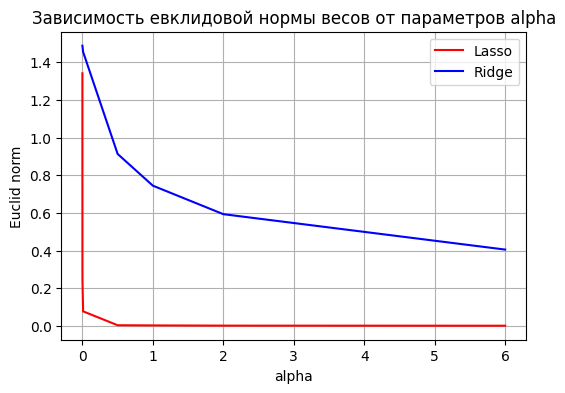

In [141]:
x = alphas
fig, ax = plt.subplots(figsize=(6,4))

y1 = lasso_euclid
y2 = ridge_euclid

ax.plot(x, y1, color='red', label='Lasso')
ax.plot(x,y2, color='blue', label='Ridge')

ax.grid(True)
plt.xlabel('alpha')
plt.ylabel('Euclid norm')
plt.title('Зависимость евклидовой нормы весов от параметров alpha')

leg = ax.legend(loc='upper right', frameon=True)

Лучшие гиперпараметры альфа для Lasso & Ridge

In [142]:
reg = LassoCV(cv=5, alphas = [0.00001, 0.0001, 0.0003, 0.0005, 0.001, 0.01, 0.5, 1, 2, 6], random_state=0).fit(X_train, y_train)
best_lasso = reg.alpha_
print('Лучший параметр альфа для Lasso: ', best_lasso)

Лучший параметр альфа для Lasso:  0.0005


In [143]:
lasso_cv = Lasso(alpha=best_lasso)
lasso_cv.fit(X_train, y_train)
print('lasso cv MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(lasso_cv.predict(X_train)-1)))
print('lasso cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test)-1)))


lasso cv MSE train:  15652990539.877956
lasso cv MSE test:  18778034325.283836


In [144]:
coef_lasso_cv = pd.DataFrame(lasso_cv.coef_, index = X.columns, columns=['coef_lasso'])
coef_lasso_cv.sort_values(by=['coef_lasso'])

,coef_lasso
Neighborhood_MeadowV,-0.046553
BldgType_Twnhs,-0.034876
BsmtQual_Gd,-0.034748
HouseStyle_1Story,-0.029740
Neighborhood_Mitchel,-0.027179
...,...
SaleCondition_Normal,0.077909
Neighborhood_StoneBr,0.086244
Street,0.093041
SaleType_New,0.113170


In [145]:
reg = RidgeCV(cv=5, alphas = [1,2,5,10,20,30]).fit(X_train, y_train)
best_ridge = reg.alpha_
print('Лучший параметр альфа для Ridge: ', best_ridge)

Лучший параметр альфа для Ridge:  10


In [146]:
ridge_cv = Ridge(alpha=best_ridge)
ridge_cv.fit(X_train, y_train)
print('ridge cv MSE train: ', mean_squared_error(math.e**(y_train)-1, math.e**(ridge_cv.predict(X_train)-1)))
print('ridge cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test)-1)))


ridge cv MSE train:  15632983720.797974
ridge cv MSE test:  18514700331.705437


In [147]:
coef_ridge_cv = pd.DataFrame(ridge_cv.coef_, index = X.columns, columns=['coef_ridge'])
coef_ridge_cv.sort_values(by=['coef_ridge'])

,coef_ridge
Neighborhood_MeadowV,-0.057013
LandSlope_Sev,-0.047002
Functional_Maj2,-0.042589
Neighborhood_Edwards,-0.040591
KitchenQual_Fa,-0.040302
...,...
BsmtFullBath,0.064935
Functional_Typ,0.068098
SaleCondition_Normal,0.073593
Neighborhood_StoneBr,0.074066


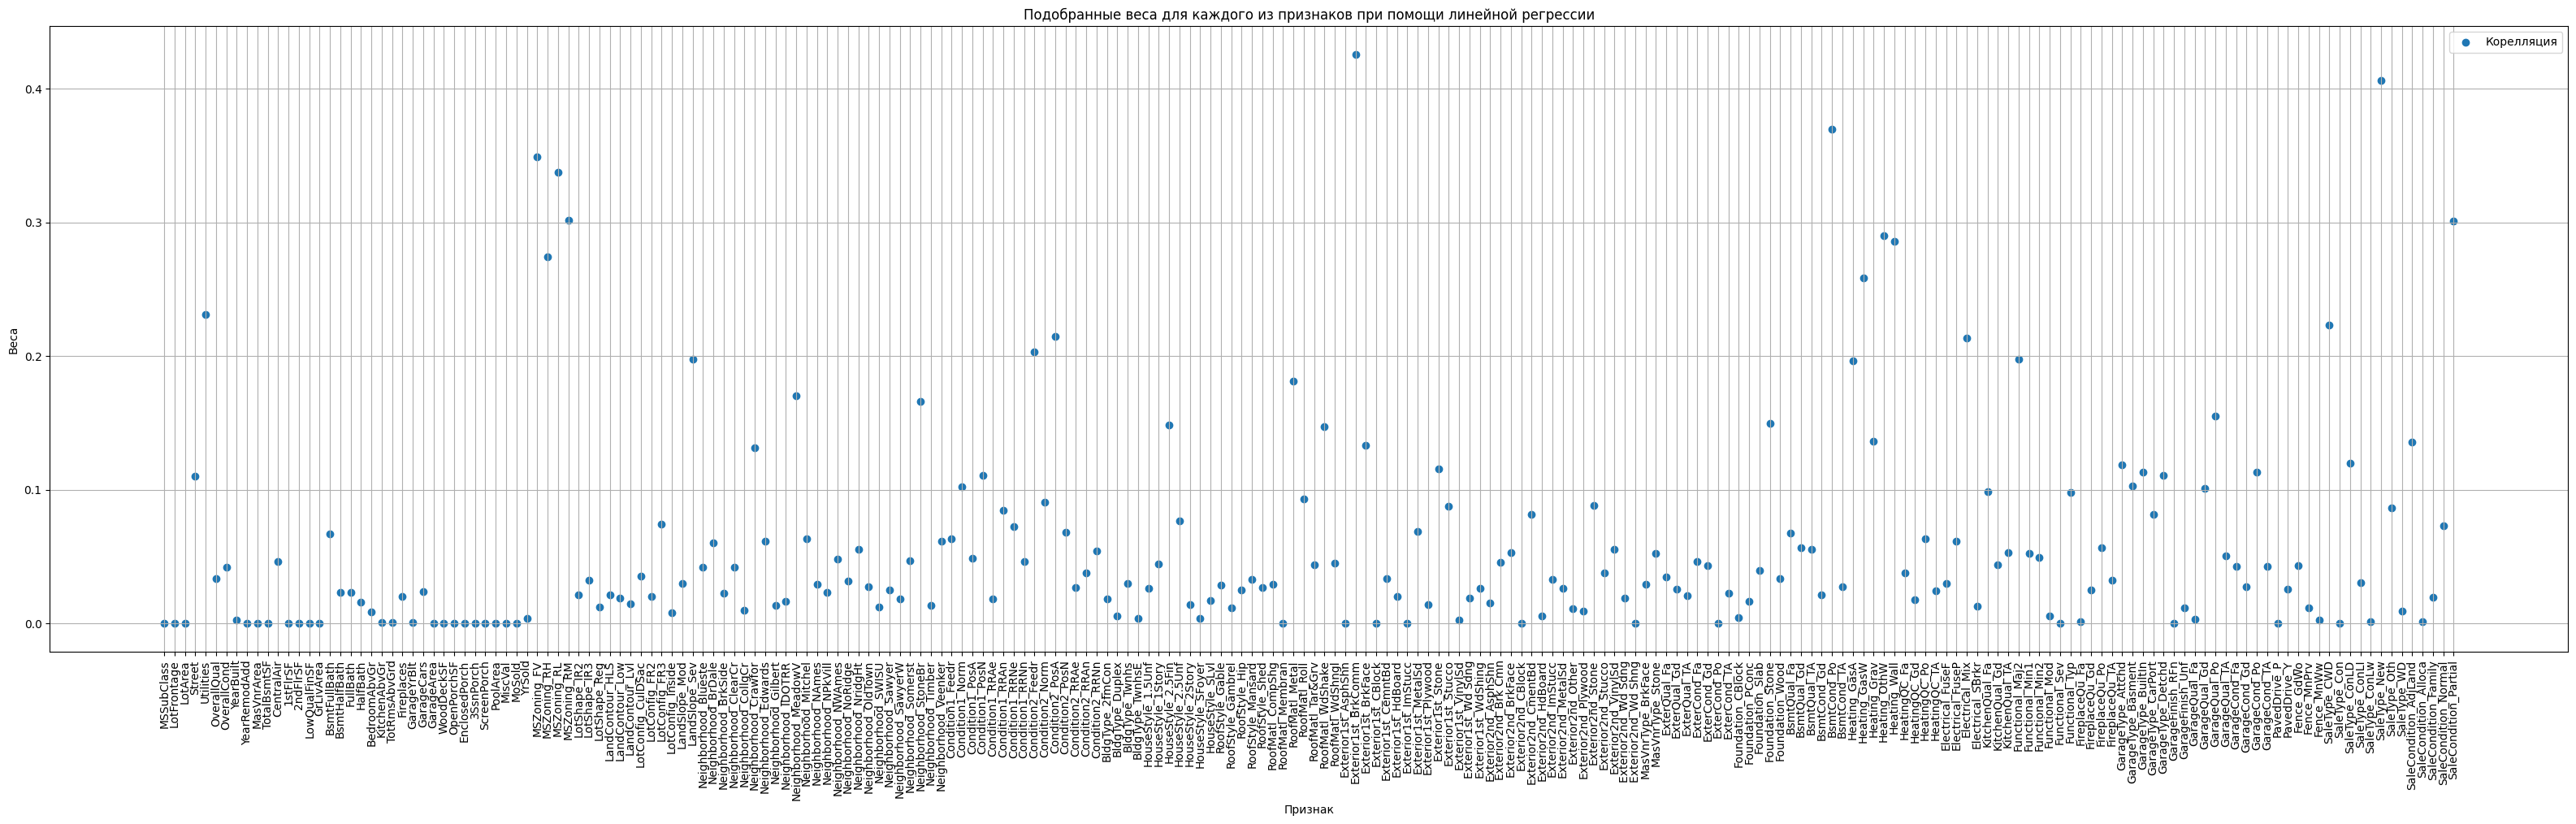

In [148]:
y1 = coef_lin_reg['coef'].abs()
fig,ax = plt.subplots(figsize = (40,10))

x = X.columns

ax.scatter(x,y1, label = 'Корелляция')
plt.xticks(rotation=90)

ax.grid(True)
plt.xlabel('Признак')
plt.ylabel('Веса')
plt.title('Подобранные веса для каждого из признаков при помощи линейной регрессии')

leg = ax.legend(loc='upper right', frameon=True)

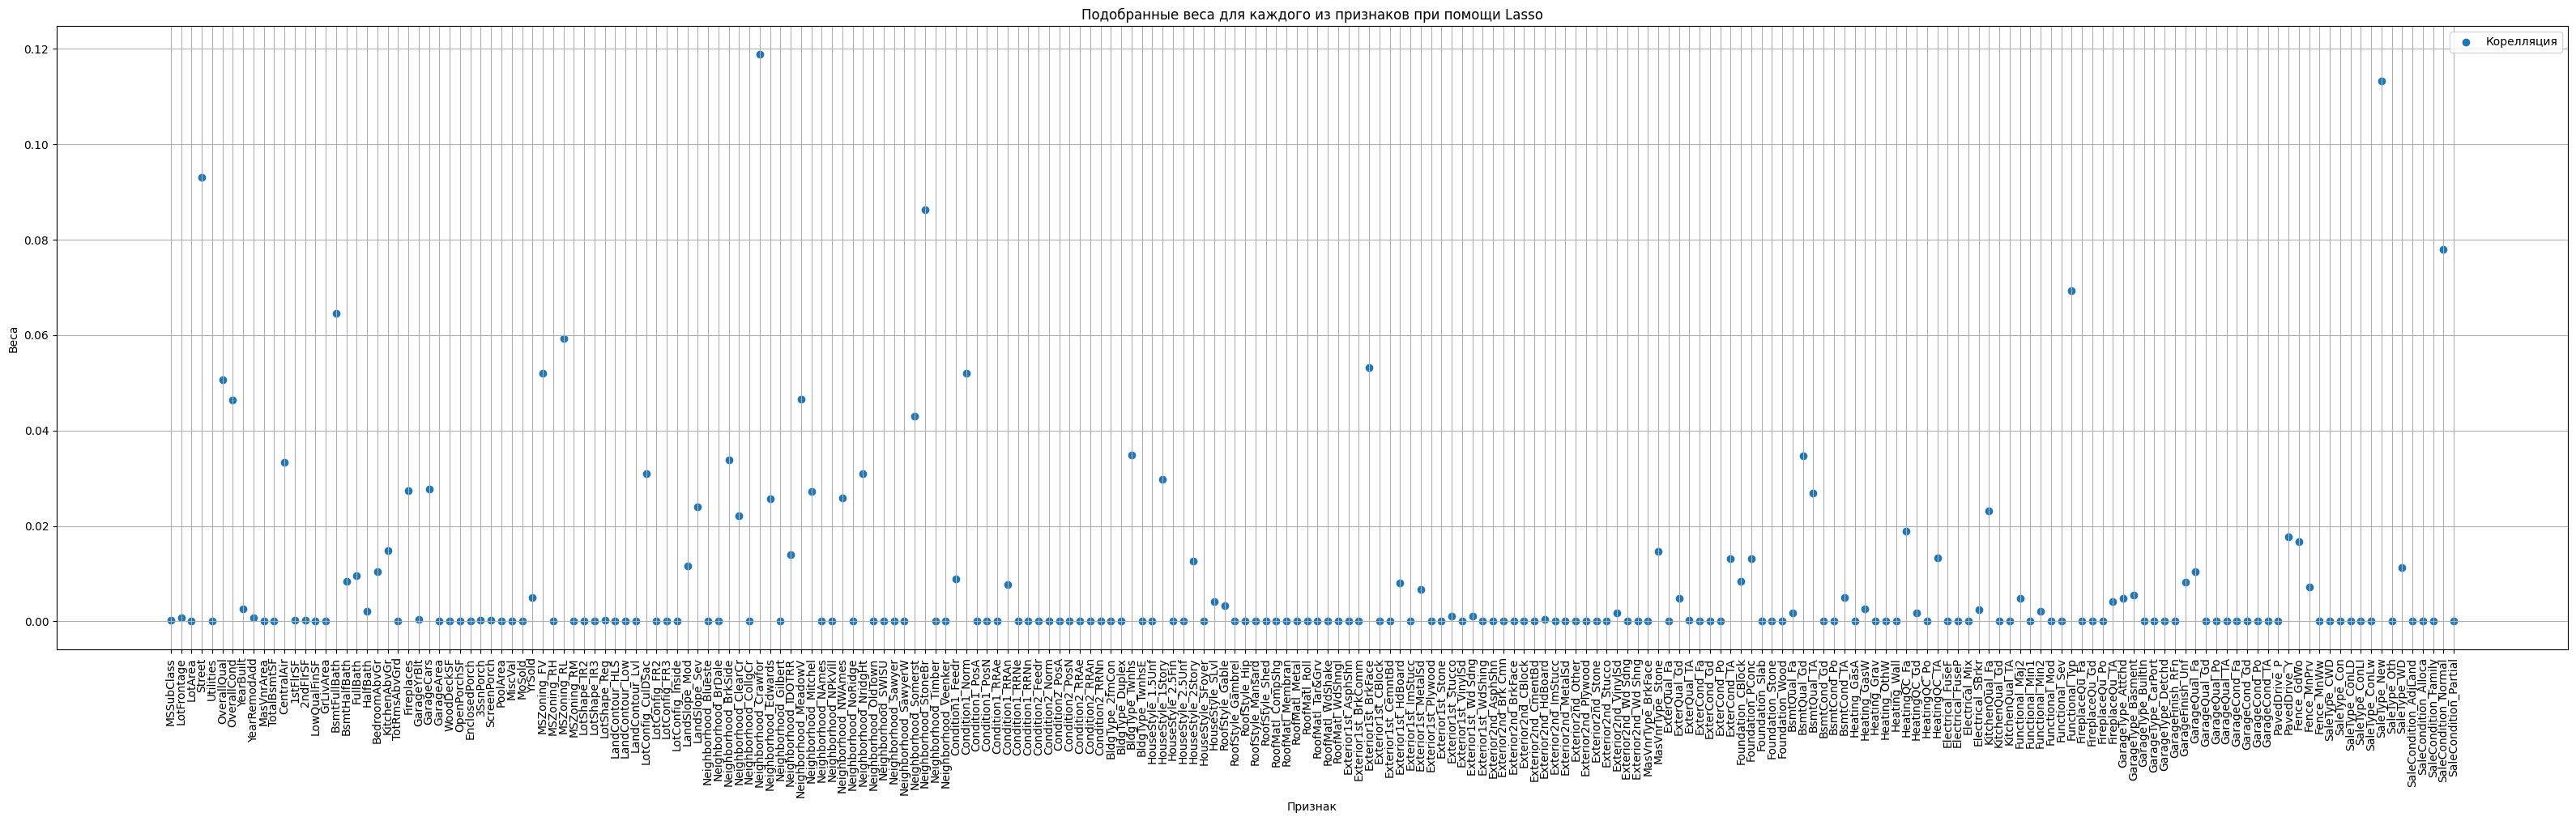

In [149]:
y1 = coef_lasso_cv['coef_lasso'].abs()
fig,ax = plt.subplots(figsize = (40,10))

x = X.columns

ax.scatter(x,y1, label = 'Корелляция')
plt.xticks(rotation=90)

ax.grid(True)
plt.xlabel('Признак')
plt.ylabel('Веса')
plt.title('Подобранные веса для каждого из признаков при помощи Lasso')

leg = ax.legend(loc='upper right', frameon=True)

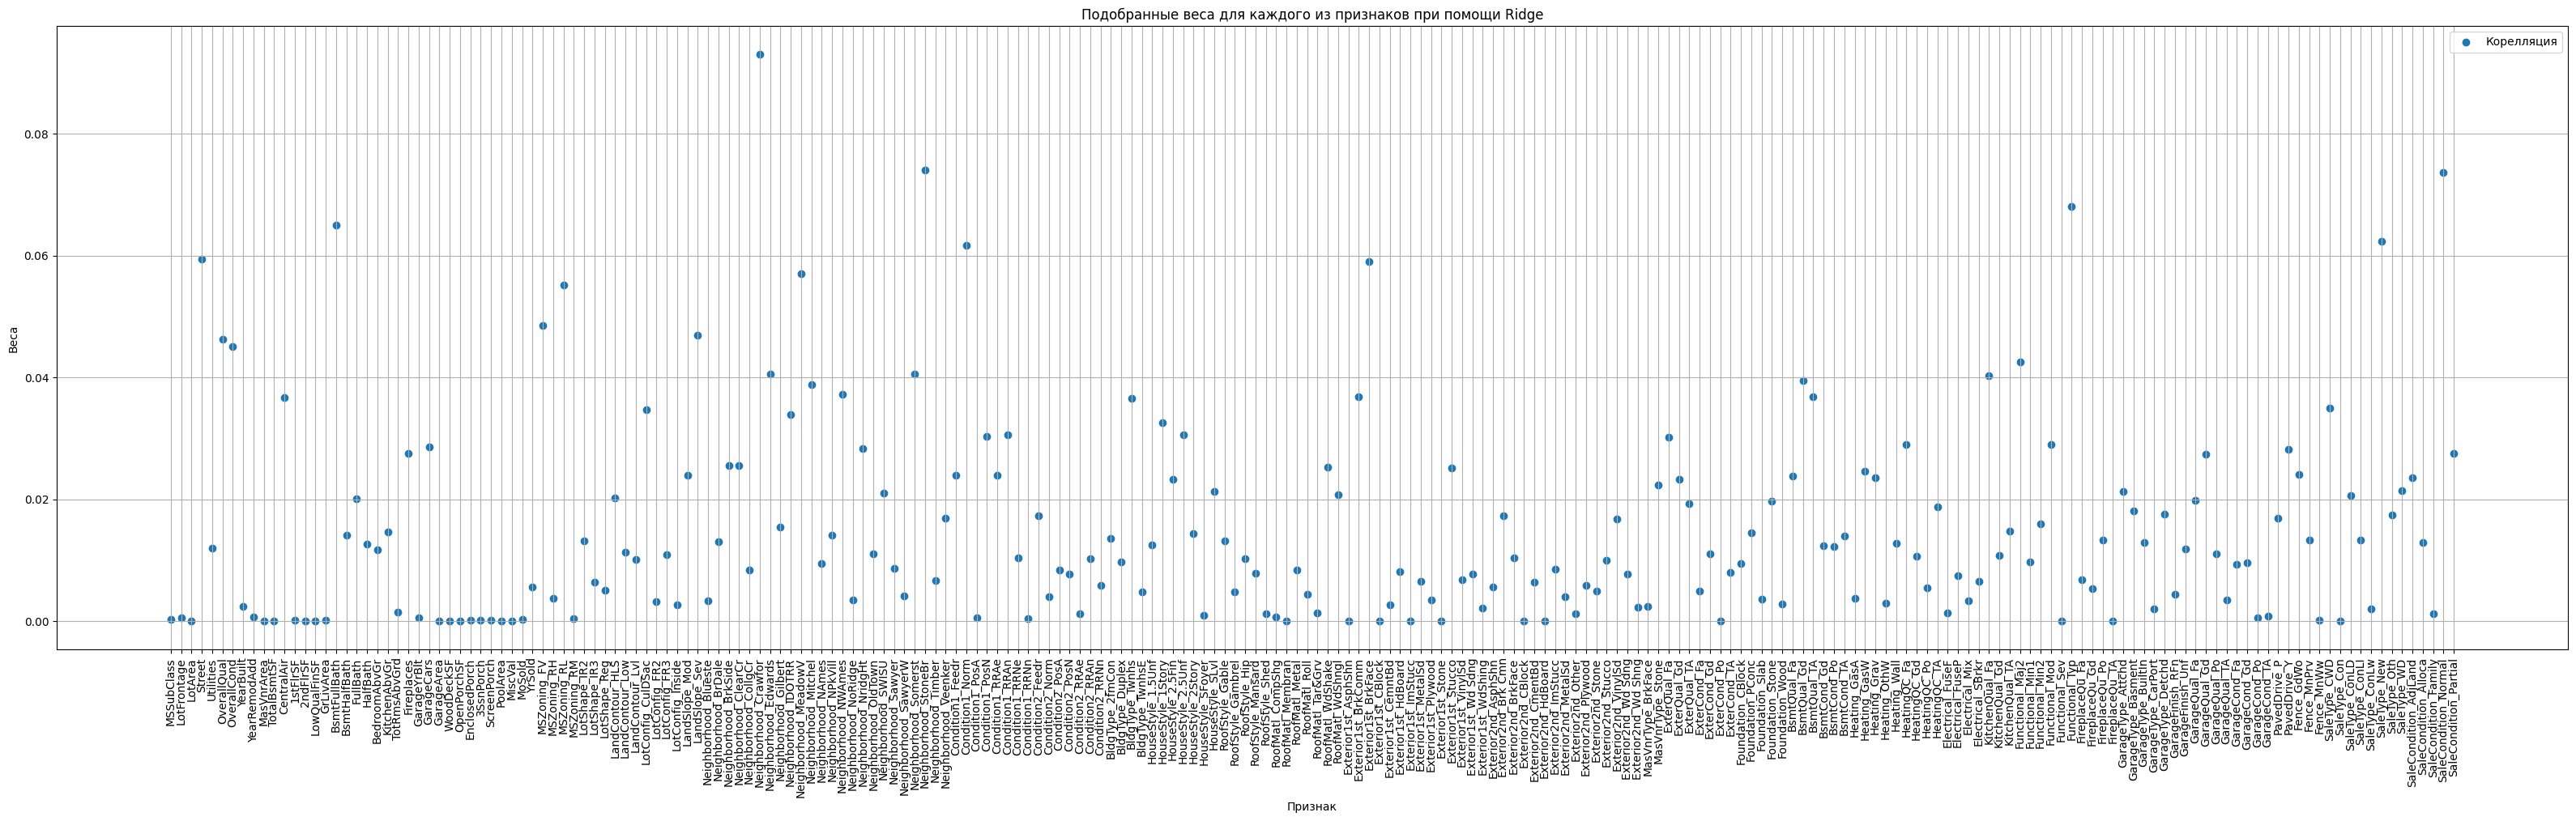

In [150]:
y1 = coef_ridge_cv['coef_ridge'].abs()
fig,ax = plt.subplots(figsize = (40,10))

x = X.columns

ax.scatter(x,y1, label = 'Корелляция')
plt.xticks(rotation=90)

ax.grid(True)
plt.xlabel('Признак')
plt.ylabel('Веса')
plt.title('Подобранные веса для каждого из признаков при помощи Ridge')

leg = ax.legend(loc='upper right', frameon=True)

In [155]:
print('lin reg MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lin_regr.predict(X_test)-1)))
print('lasso cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(lasso_cv.predict(X_test)-1)))
print('ridge cv MSE test: ', mean_squared_error(math.e**(y_test)-1, math.e**(ridge_cv.predict(X_test)-1)))


lin reg MSE test:  18082470402.683346
lasso cv MSE test:  18778034325.283836
ridge cv MSE test:  18514700331.705437


На MSE тесте значение ошибки линейной регрессии оказалось меньше, чем при Lasso и Ridge